In [1]:
# E91 Quantum Key Distribution Simulator
# Comprehensive simulation framework for E91 protocol over different channel types

# ========================== Import Libraries ==========================
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, pi, sqrt, log2, exp
from enum import Enum
from typing import Tuple, Dict, List, Optional
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib style for better plots
plt.style.use('seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else 'default')

# ========================== Channel Class ==========================
class ChannelType(Enum):
    FIBER = "fiber"
    FSO = "fso"  # Free Space Optical

class QuantumChannel:
    """
    Quantum channel class supporting both fiber and FSO transmission
    """
    
    def __init__(self, channel_type: ChannelType):
        self.channel_type = channel_type
        self._set_channel_parameters()
    
    def _set_channel_parameters(self):
        """Set channel-specific parameters"""
        if self.channel_type == ChannelType.FIBER:
            # Fiber channel parameters
            self.alpha_db = 0.2            # Atmospheric attenuation (dB/km)
            self.max_distance = 300        # Maximum practical distance (km)
            self.noise_components = {
                'raman': 5e-5,             # Raman scattering noise
                'dark': 5e-6               # Dark count noise
            }
        
        elif self.channel_type == ChannelType.FSO:
            # Free Space Optical parameters
            self.alpha_db = 0.1            # Atmospheric attenuation (dB/km)
            self.max_distance = 50         # Maximum practical distance (km)
            self.beam_divergence = 0.001e-3  # Beam divergence (rad)
            self.tx_aperture = 0.1        # Transmitter aperture diameter (m)
            self.rx_aperture = 0.3        # Receiver aperture diameter (m)
            self.noise_components = {
                'stray': 5e-6,             # Stray light noise
                'dark': 5e-6               # Dark count noise
            }
        
        # Convert dB/km to 1/km for calculations
        self.alpha_linear = self.alpha_db / 4.343
        self.total_noise_prob = sum(self.noise_components.values())
    
    def transmittance(self, distance_km: float) -> float:
        """
        Calculate channel transmittance for given distance
        
        Args:
            distance_km: Distance in kilometers
            
        Returns:
            Transmittance value between 0 and 1
        """
        if self.channel_type == ChannelType.FIBER:
            # Fiber: Only atmospheric/material losses
            return 10 ** (-self.alpha_db * distance_km / 10)
        
        elif self.channel_type == ChannelType.FSO:
            # FSO: Geometric spreading + atmospheric losses
            distance_m = distance_km * 1000
            
            # Geometric loss due to beam divergence
            geo_loss = (self.rx_aperture / (self.tx_aperture + self.beam_divergence * distance_m)) ** 2
            
            # Atmospheric loss
            atm_loss = exp(-self.alpha_linear * distance_km)
            
            return geo_loss * atm_loss
    
    def get_channel_info(self) -> Dict:
        """Return channel configuration information"""
        return {
            'type': self.channel_type.value,
            'alpha_db': self.alpha_db,
            'max_distance': self.max_distance,
            'noise_components': self.noise_components,
            'total_noise': self.total_noise_prob
        }
    
    def update_parameters(self, **kwargs):
        """Update channel parameters dynamically"""
        for key, value in kwargs.items():
            if hasattr(self, key):
                setattr(self, key, value)
                if key == 'alpha_db':
                    self.alpha_linear = value / 4.343
                elif key in ['raman', 'dark', 'stray']:
                    self.noise_components[key] = value
                    self.total_noise_prob = sum(self.noise_components.values())

    def get_misalignment_error(self, distance_km):
        base = 0.015
        factor = 0.0002
        return min(0.1, base + factor * distance_km)
    
    
# ========================== Detector Class ==========================
class QuantumDetector:
    """
    Quantum detector system for photon pair detection
    """
    
    def __init__(self, detector_efficiency=0.6, collection_efficiency=0.6, mu=0.1):
        self.eta_detector = detector_efficiency
        self.eta_collection = collection_efficiency
        self.eta_total = self.eta_detector * self.eta_collection
        self.mu = mu  # Mean photon pair number per pulse

        # SPDC-based source
        self.pulse_rate = 80e6  # 80 MHz clock
        self.afterpulsing_prob = 0.02
        self.timing_jitter_error = 0.01
        
    def compute_detection_probabilities(self, transmittance: float) -> Dict[str, float]:
        """
        Compute detection probabilities for different photon number states
        
        Args:
            transmittance: Channel transmittance
            
        Returns:
            Dictionary with probabilities for different detection scenarios
        """
        T = transmittance
        
        # Photon number state probabilities after transmission
        p_both = T ** 2          # Both photons arrive
        p_single = 2 * T * (1 - T)  # One photon arrives
        p_none = (1 - T) ** 2    # No photons arrive
        
        return {
            'p_both_arrive': p_both,
            'p_single_arrive': p_single,
            'p_none_arrive': p_none
        }
    
    def compute_photon_detection_probability(self, max_photons=10):
        """
        Compute effective detection probability considering SPDC source statistics.
        """
        prob_total = 0
        for n in range(1, max_photons + 1):
            p_n = self.spdc_photon_distribution(n)
            p_det = 1 - (1 - self.eta_total) ** n
            prob_total += p_n * p_det * self.compute_saturation_factor(n)
        
        # Apply detector nonidealities
        prob_total *= (1 - self.afterpulsing_prob) * (1 - self.timing_jitter_error)
        return prob_total
        
    def compute_click_probability(self, noise_prob: float) -> float:
        """
        Compute probability of detector click (including noise)
        
        Args:
            noise_prob: Total noise probability per detector
            
        Returns:
            Click probability
        """
        base_click = self.eta_total + 2 * noise_prob * (1 - self.eta_total)
        afterpulse_penalty = 1 + self.afterpulsing_prob
        return min(1.0, base_click * afterpulse_penalty)
    
    def compute_normalization_factor(self, transmittance: float, noise_prob: float) -> float:
        """
        Compute normalization factor N for correlation calculations,
        using realistic detection probability with saturation.
        
        Args:
            transmittance: Channel transmittance
            noise_prob: Total noise probability
        
        Returns:
            Normalization factor N
        """
        probs = self.compute_detection_probabilities(transmittance)

        # Estimate 1 photon per detection arm on average
        eta_eff = self.compute_photon_detection_probability()

        # Numerator: Both photons detected successfully with realistic efficiency
        numerator = probs['p_both_arrive'] * (eta_eff ** 2)

        # Adjusted total click probability using eta_eff
        click_prob = eta_eff + 2 * noise_prob * (1 - eta_eff)

        # Denominator: All cases of clicks (both signal + noise)
        denominator = (
            probs['p_both_arrive'] * (click_prob ** 2) +
            2 * probs['p_single_arrive'] * noise_prob * click_prob +
            4 * probs['p_none_arrive'] * (noise_prob ** 2)
        )

        return numerator / denominator if denominator > 0 else 0
    
    def update_efficiency(self, detector_eff: Optional[float] = None, 
                         collection_eff: Optional[float] = None):
        """Update detector efficiencies"""
        if detector_eff is not None:
            self.eta_detector = detector_eff
        if collection_eff is not None:
            self.eta_collection = collection_eff
        self.eta_total = self.eta_detector * self.eta_collection

    def compute_saturation_factor(self, photons: int) -> float:
        # More realistic saturation curve
        return 1.0 / (1.0 + 0.1 * photons) if photons > 1 else 1.0
    
    def spdc_photon_distribution(self, n):
        """Thermal photon-pair distribution from SPDC: P(n) = (1 - μ)^n * μ / (1 + μ)^(n+1)"""
        mu = self.mu
        return (mu ** n) / ((1 + mu) ** (n + 1))

    
# ========================== E91 Simulator Class ==========================
class E91Simulator:
    """
    Complete E91 quantum key distribution simulator
    Supports center-source configuration with physics realism.
    """

    def __init__(self, channel: QuantumChannel, detector: QuantumDetector, distance_km: float):
        self.channel = channel
        self.detector = detector
        self.distance_km = distance_km  # store for reuse

        # Bell test measurement settings (CHSH inequality)
        self.measurement_angles = {
            'alice_1': 0,
            'alice_2': pi / 4,
            'bob_1': -pi / 8,
            'bob_2': pi / 8
        }

        self.entanglement_phase = pi
        self.simulation_results = {}

        # ✅ Add center-source support:
        half_distance = distance_km / 2

        self.channel_alice = QuantumChannel(channel.channel_type)
        self.channel_bob = QuantumChannel(channel.channel_type)

        # Copy configuration and update distances
        self.channel_alice.update_parameters(**channel.get_channel_info())
        self.channel_bob.update_parameters(**channel.get_channel_info())


    
    @staticmethod
    def binary_entropy(x: float) -> float:
        """
        Calculate binary entropy function H(x) = -x*log₂(x) - (1-x)*log₂(1-x)
        
        Args:
            x: Probability value between 0 and 1
            
        Returns:
            Binary entropy value
        """
        epsilon = 1e-12
        x = np.clip(x, epsilon, 1 - epsilon)
        return -x * log2(x) - (1 - x) * log2(1 - x)
    
    def correlation_function(self, theta_alice: float, theta_bob: float, 
                           normalization: float, phase: float) -> float:
        """
        Calculate correlation function E(θₐ, θᵦ) for given measurement angles
        
        Args:
            theta_alice: Alice's measurement angle
            theta_bob: Bob's measurement angle
            normalization: Normalization factor N
            phase: Entanglement phase
            
        Returns:
            Correlation value
        """
        term1 = -cos(2 * theta_alice) * cos(2 * theta_bob)
        term2 = cos(phase) * sin(2 * theta_alice) * sin(2 * theta_bob)
        return normalization * (term1 + term2)
    
    def compute_bell_parameter(self, normalization: float, phase: float) -> float:
        """
        Compute Bell parameter S for CHSH inequality
        
        Args:
            normalization: Normalization factor N
            phase: Entanglement phase
            
        Returns:
            Bell parameter S
        """
        angles = self.measurement_angles
        
        # Calculate four correlation functions
        E11 = self.correlation_function(angles['alice_1'], angles['bob_1'], 
                                       normalization, phase)
        E12 = self.correlation_function(angles['alice_1'], angles['bob_2'], 
                                       normalization, phase)
        E21 = self.correlation_function(angles['alice_2'], angles['bob_1'], 
                                       normalization, phase)
        E22 = self.correlation_function(angles['alice_2'], angles['bob_2'], 
                                       normalization, phase)
        
        # CHSH combination: S = |E₁₁ + E₁₂ - E₂₁ + E₂₂|
        S = abs(E11 + E12 - E21 + E22)
        
        return S
    
    def compute_qber(self, bell_parameter: float) -> float:
        """
        Compute Quantum Bit Error Rate (QBER) from Bell parameter
        
        Args:
            bell_parameter: Bell parameter S
            
        Returns:
            QBER value
        """
        # Clip S to valid range [0, 2√2]
        S = np.clip(bell_parameter, 0, 2 * sqrt(2))
        return 0.5 * (1 - S / (2 * sqrt(2)))
    
    def compute_secret_key_rate(self, bell_parameter: float, qber: float, 
                              transmittance: float) -> float:
        """
        Compute Secret Key Rate using Acín et al.'s formula
        
        Args:
            bell_parameter: Bell parameter S
            qber: Quantum bit error rate
            transmittance: Channel transmittance
            
        Returns:
            Secret key rate in bits per second
        """
        S = bell_parameter
        
        # No key extraction possible if S ≤ 2 (no Bell violation)
        if S <= 2:
            return 0
        
        # Acín et al. formula term
        term = (1 + sqrt(S**2 / 4 - 1)) / 2
        
        # SKR = (1/3) * ν * T * [1 - H(Q) - H(term)]
        pair_rate = self.detector.pulse_rate * self.detector.mu
        skr = (1/3) * pair_rate * transmittance * \
              (1 - self.binary_entropy(qber) - self.binary_entropy(term))
        
        return max(0, skr)  # Ensure non-negative
    
    def simulate_single_distance(self, distance_km: float, p_eve: float = 0.0) -> Dict:
        """
        Simulate E91 protocol for a single distance with optional eavesdropping.

        Args:
            distance_km: Distance in kilometers
            p_eve: Eavesdropping probability (0 = no Eve, 1 = full decoherence)
        """
        T_A = self.channel_alice.transmittance(distance_km / 2)
        T_B = self.channel_bob.transmittance(distance_km / 2)
        T = T_A * T_B

        N_raw = self.detector.compute_normalization_factor(T, self.channel.total_noise_prob)

        # ❗ Apply decoherence from eavesdropping
        N = (1 - p_eve) * N_raw

        S = self.compute_bell_parameter(N, self.entanglement_phase)
        Q = self.compute_qber(S)
        Q += self.detector.timing_jitter_error
        Q += self.channel.get_misalignment_error(distance_km)
        Q = min(0.5, Q)

        SKR = self.compute_secret_key_rate(S, Q, T)

        return {
            'distance': distance_km,
            'transmittance': T,
            'normalization': N,
            'bell_parameter': S,
            'qber': Q,
            'qber_percent': Q * 100,
            'secret_key_rate': SKR,
            'bell_violation': S > 2,
            'secure_communication': S > 2 and Q < 0.146
    }

    
    def simulate_distance_range(self, min_distance: float = 0.01, 
                              max_distance: Optional[float] = None,
                              num_points: int = 300) -> Dict:
        """
        Simulate E91 protocol over a range of distances
        
        Args:
            min_distance: Minimum distance in km
            max_distance: Maximum distance in km (uses channel max if None)
            num_points: Number of distance points to simulate
            
        Returns:
            Dictionary with arrays of simulation results
        """
        if max_distance is None:
            max_distance = self.channel.max_distance
        
        distances = np.linspace(min_distance, max_distance, num_points)
        
        results = {
            'distances': distances,
            'transmittances': [],
            'bell_parameters': [],
            'qbers': [],
            'qber_percents': [],
            'secret_key_rates': [],
            'bell_violations': [],
            'secure_regions': []
        }
        
        for distance in distances:
            single_result = self.simulate_single_distance(distance)
            
            results['transmittances'].append(single_result['transmittance'])
            results['bell_parameters'].append(single_result['bell_parameter'])
            results['qbers'].append(single_result['qber'])
            results['qber_percents'].append(single_result['qber_percent'])
            results['secret_key_rates'].append(single_result['secret_key_rate'])
            results['bell_violations'].append(single_result['bell_violation'])
            results['secure_regions'].append(single_result['secure_communication'])
        
        # Convert lists to numpy arrays for easier manipulation
        for key in results:
            if key != 'distances':
                results[key] = np.array(results[key])
        
        # Store results for later use
        self.simulation_results = results
        
        return results
    
    def update_measurement_angles(self, **angles):
        """
        Update measurement angles for Bell test
        
        Args:
            **angles: Keyword arguments for angle updates
                     (alice_1, alice_2, bob_1, bob_2)
        """
        for key, value in angles.items():
            if key in self.measurement_angles:
                self.measurement_angles[key] = value
    
    def get_simulation_summary(self) -> Dict:
        """Get summary of current simulation setup"""
        return {
            'channel_info': self.channel.get_channel_info(),
            'detector_efficiency': self.detector.eta_total,
            'measurement_angles': self.measurement_angles,
            'entanglement_phase': self.entanglement_phase
        }

# ========================== Example Usage ==========================
print("E91 QKD Simulator Classes Initialized Successfully!")
print("\nAvailable Classes:")
print("- QuantumChannel: Models fiber and FSO channels")
print("- QuantumDetector: Simulates photon detection systems") 
print("- E91Simulator: Complete E91 protocol simulation")
print("\nExample instantiation:")
print("channel = QuantumChannel(ChannelType.FIBER)")
print("detector = QuantumDetector()")
print("simulator = E91Simulator(channel, detector)")

def plot_qber_vs_mu(mu_values=None, distance=50, channel_type="fiber", **kwargs):
    if mu_values is None:
        mu_values = np.linspace(0.001, 0.5, 40)

    qbers = []
    for mu in mu_values:
        channel = QuantumChannel(ChannelType.FIBER if channel_type == "fiber" else ChannelType.FSO)
        detector = QuantumDetector(mu=mu, **kwargs)
        sim = E91Simulator(channel, detector, distance_km=distance)
        result = sim.simulate_single_distance(distance)
        qbers.append(result['qber_percent'])

    plt.figure(figsize=(10, 6))
    plt.plot(mu_values, qbers, 'bo-', label='QBER')
    plt.axhline(11, color='red', linestyle='--', label='QBER Threshold (11%)')
    plt.grid(True)
    plt.xlabel('Mean Photon Pair Number per Pulse (μ)', fontsize=18)
    plt.ylabel('QBER (%)', fontsize=18)
    plt.title(f'QBER vs μ ({channel_type.upper()})', fontsize=20)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()


def plot_skr_vs_mu(mu_values=None, distance=50, channel_type="fiber",
                  detector_efficiency=0.6, collection_efficiency=0.6,
                  receiver_diameter=0.1, transmitter_diameter=0.01, 
                  beam_divergence=1e-6, atmospheric_attenuation=0.1,
                  pulse_rate=80e6):
    """
    Plot Secret Key Rate (SKR) vs mean photon pair number per pulse (μ) for E91.
    """
    if mu_values is None:
        mu_values = np.linspace(0.001, 0.5, 40)

    skr_values = []

    for mu in mu_values:
        channel = QuantumChannel(ChannelType.FIBER if channel_type == "fiber" else ChannelType.FSO)
        if channel_type == "fso":
            channel.update_parameters(
                rx_aperture=receiver_diameter,
                tx_aperture=transmitter_diameter,
                beam_divergence=beam_divergence,
                alpha_db=atmospheric_attenuation * 4.343
            )

        detector = QuantumDetector(detector_efficiency, collection_efficiency, mu=mu)
        detector.pulse_rate = pulse_rate

        sim = E91Simulator(channel, detector, distance_km=distance)
        result = sim.simulate_single_distance(distance)
        skr_values.append(result['secret_key_rate'])

    plt.figure(figsize=(10, 6))
    plt.plot(mu_values, skr_values, 'go-', linewidth=2, markersize=8, label='SKR')
    plt.grid(True)
    plt.xlabel('Mean Photon Pair Number per Pulse (μ)', fontsize=18)
    plt.ylabel('Secret Key Rate (bps)', fontsize=18)
    plt.title(f'SKR vs μ ({channel_type.upper()}, {distance} km)', fontsize=20)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

    return mu_values, skr_values

def plot_bell_violation_vs_mu(mu_values=None, distance=50, channel_type="fiber",
                               detector_efficiency=0.6, collection_efficiency=0.6,
                               receiver_diameter=0.1, transmitter_diameter=0.01,
                               beam_divergence=1e-6, atmospheric_attenuation=0.1,
                               pulse_rate=80e6):
    """
    Plot Bell Parameter S vs mean photon pair number per pulse (μ) for E91.
    """
    if mu_values is None:
        mu_values = np.linspace(0.001, 0.5, 40)

    S_values = []

    for mu in mu_values:
        channel = QuantumChannel(ChannelType.FIBER if channel_type == "fiber" else ChannelType.FSO)
        if channel_type == "fso":
            channel.update_parameters(
                rx_aperture=receiver_diameter,
                tx_aperture=transmitter_diameter,
                beam_divergence=beam_divergence,
                alpha_db=atmospheric_attenuation * 4.343
            )

        detector = QuantumDetector(detector_efficiency, collection_efficiency, mu=mu)
        detector.pulse_rate = pulse_rate

        sim = E91Simulator(channel, detector, distance_km=distance)
        result = sim.simulate_single_distance(distance)
        S_values.append(result['bell_parameter'])

    plt.figure(figsize=(10, 6))
    plt.plot(mu_values, S_values, 'ro-', linewidth=2, markersize=8, label='S')
    plt.axhline(2, color='gray', linestyle='--', linewidth=2, label='Classical Limit (S=2)')
    plt.grid(True)
    plt.xlabel('Mean Photon Pair Number per Pulse (μ)', fontsize=18)
    plt.ylabel('Bell Parameter S', fontsize=18)
    plt.title(f'Bell Violation S vs μ ({channel_type.upper()}, {distance} km)', fontsize=20)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

    return mu_values, S_values


def plot_qber_vs_distance(distance_range=(1, 300), num_points=50,
                          detector_efficiency=0.6, collection_efficiency=0.6,
                          channel_type="fiber", 
                          receiver_diameter=0.1, transmitter_diameter=0.01,
                          beam_divergence=1e-6, atmospheric_attenuation=0.1,
                          pair_generation_rate=0.64e6):
    """
    Plot QBER vs distance for E91 protocol over fiber or FSO channel.
    """
    distances = np.linspace(*distance_range, num_points)
    qbers = []

    for d in distances:
        channel = QuantumChannel(ChannelType.FIBER if channel_type == "fiber" else ChannelType.FSO)
        if channel_type == "fso":
            channel.update_parameters(
                rx_aperture=receiver_diameter,
                tx_aperture=transmitter_diameter,
                beam_divergence=beam_divergence,
                alpha_db=atmospheric_attenuation * 4.343
            )

        detector = QuantumDetector(detector_efficiency, collection_efficiency)
        detector.pair_generation_rate = pair_generation_rate

        sim = E91Simulator(channel, detector, distance_km=d)
        result = sim.simulate_single_distance(d)
        qbers.append(result['qber_percent'])

    plt.figure(figsize=(10, 6))
    plt.plot(distances, qbers, 'bo-', linewidth=2, markersize=6, label='QBER')
    plt.axhline(5, color='magenta', linestyle='--', label='5% Threshold')
    plt.axhline(11, color='red', linestyle='--', label='11% Threshold')
    plt.grid(True)
    plt.xlabel('Distance (km)', fontsize=18)
    plt.ylabel('QBER (%)', fontsize=18)
    plt.title(f'QBER vs Distance ({channel_type.upper()})', fontsize=20)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

    return distances, qbers

def plot_skr_vs_distance(distance_range=(1, 300), num_points=300,
                         detector_efficiency=0.6, collection_efficiency=0.6,
                         channel_type="fiber", 
                         receiver_diameter=0.1, transmitter_diameter=0.01,
                         beam_divergence=1e-6, atmospheric_attenuation=0.1,
                         pair_generation_rate=0.64e6):
    """
    Plot Secret Key Rate (SKR) vs distance for E91 protocol.
    """
    distances = np.linspace(*distance_range, num_points)
    skr_values = []

    for d in distances:
        channel = QuantumChannel(ChannelType.FIBER if channel_type == "fiber" else ChannelType.FSO)
        if channel_type == "fso":
            channel.update_parameters(
                rx_aperture=receiver_diameter,
                tx_aperture=transmitter_diameter,
                beam_divergence=beam_divergence,
                alpha_db=atmospheric_attenuation * 4.343
            )

        detector = QuantumDetector(detector_efficiency, collection_efficiency)
        detector.pair_generation_rate = pair_generation_rate

        sim = E91Simulator(channel, detector, distance_km=d)
        result = sim.simulate_single_distance(d)
        skr_values.append(result['secret_key_rate'])

    plt.figure(figsize=(10, 6))
    plt.plot(distances, skr_values, 'go-', linewidth=2, markersize=6, label='SKR')
    plt.grid(True)
    plt.xlabel('Distance (km)', fontsize=18)
    plt.ylabel('Secret Key Rate (bps)', fontsize=18)
    plt.title(f'Secret Key Rate vs Distance ({channel_type.upper()})', fontsize=20)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

    return distances, skr_values

def plot_bell_violation_vs_distance(distance_range=(1, 300), num_points=300,
                                    detector_efficiency=0.6, collection_efficiency=0.6,
                                    channel_type="fiber", 
                                    receiver_diameter=0.1, transmitter_diameter=0.01,
                                    beam_divergence=1e-6, atmospheric_attenuation=0.1,
                                    pair_generation_rate=0.64e6):
    """
    Plot Bell parameter S vs distance for E91 protocol.
    """
    distances = np.linspace(*distance_range, num_points)
    S_values = []

    for d in distances:
        channel = QuantumChannel(ChannelType.FIBER if channel_type == "fiber" else ChannelType.FSO)
        if channel_type == "fso":
            channel.update_parameters(
                rx_aperture=receiver_diameter,
                tx_aperture=transmitter_diameter,
                beam_divergence=beam_divergence,
                alpha_db=atmospheric_attenuation * 4.343
            )

        detector = QuantumDetector(detector_efficiency, collection_efficiency)
        detector.pair_generation_rate = pair_generation_rate

        sim = E91Simulator(channel, detector, distance_km=d)
        result = sim.simulate_single_distance(d)
        S_values.append(result['bell_parameter'])

    plt.figure(figsize=(10, 6))
    plt.plot(distances, S_values, 'ro-', linewidth=2, markersize=6, label='S')
    plt.axhline(2, color='gray', linestyle='--', linewidth=2, label='Classical Limit (S=2)')
    plt.grid(True)
    plt.xlabel('Distance (km)', fontsize=18)
    plt.ylabel('Bell Parameter S', fontsize=18)
    plt.title(f'Bell Violation S vs Distance ({channel_type.upper()})', fontsize=20)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

    return distances, S_values

def plot_qber_vs_eavesdropping(p_eve_values=None, distance_km=20,
                                detector_efficiency=0.6, collection_efficiency=0.6,
                                channel_type="fiber", pair_generation_rate=0.64e6):
    """
    Plot QBER vs eavesdropping strength p_eve in E91.
    """
    if p_eve_values is None:
        p_eve_values = np.linspace(0, 1, 50)

    qbers = []

    for p_eve in p_eve_values:
        channel = QuantumChannel(ChannelType.FIBER if channel_type == "fiber" else ChannelType.FSO)
        detector = QuantumDetector(detector_efficiency, collection_efficiency)
        detector.pair_generation_rate = pair_generation_rate

        sim = E91Simulator(channel, detector, distance_km)
        result = sim.simulate_single_distance(distance_km, p_eve=p_eve)
        qbers.append(result['qber_percent'])

    plt.figure(figsize=(10, 6))
    plt.plot(p_eve_values, qbers, 'bo-', linewidth=2, label='QBER (%)')
    plt.axhline(11, color='red', linestyle='--', label='11% Threshold')
    plt.grid(True)
    plt.xlabel('Eavesdropping Probability $p_{eve}$', fontsize=18)
    plt.ylabel('QBER (%)', fontsize=18)
    plt.title(f'QBER vs Eavesdropping Strength ({channel_type.upper()}, {distance_km} km)', fontsize=20)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

    return p_eve_values, qbers

E91 QKD Simulator Classes Initialized Successfully!

Available Classes:
- QuantumChannel: Models fiber and FSO channels
- QuantumDetector: Simulates photon detection systems
- E91Simulator: Complete E91 protocol simulation

Example instantiation:
channel = QuantumChannel(ChannelType.FIBER)
detector = QuantumDetector()
simulator = E91Simulator(channel, detector)


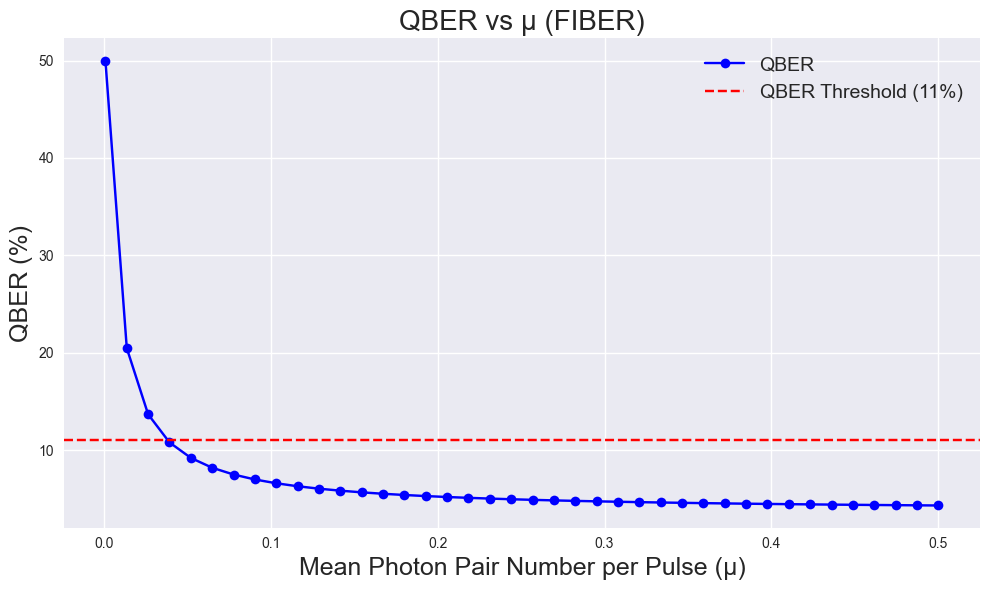

In [8]:
plot_qber_vs_mu()

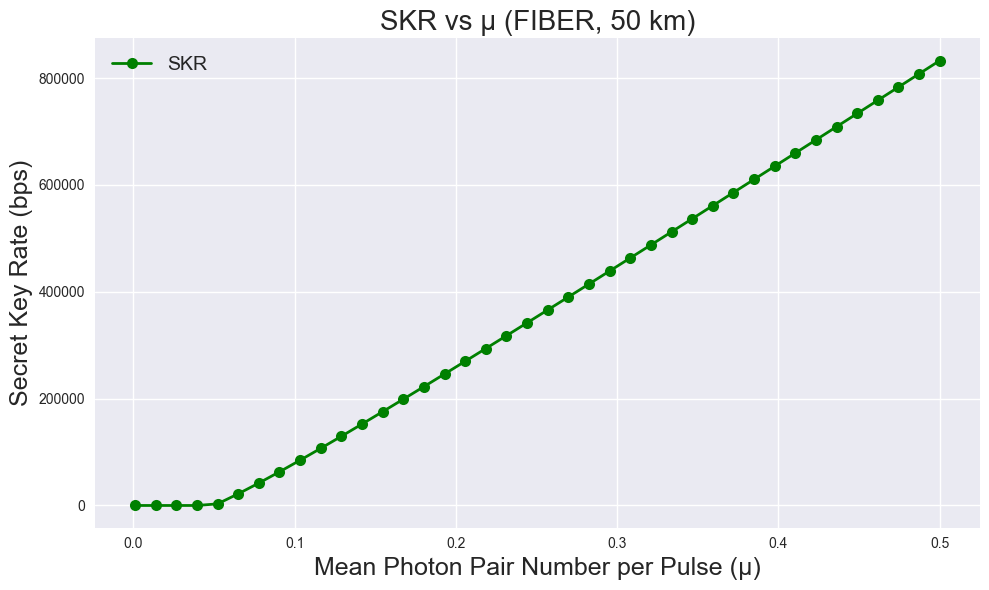

(array([0.001     , 0.01379487, 0.02658974, 0.03938462, 0.05217949,
        0.06497436, 0.07776923, 0.0905641 , 0.10335897, 0.11615385,
        0.12894872, 0.14174359, 0.15453846, 0.16733333, 0.18012821,
        0.19292308, 0.20571795, 0.21851282, 0.23130769, 0.24410256,
        0.25689744, 0.26969231, 0.28248718, 0.29528205, 0.30807692,
        0.32087179, 0.33366667, 0.34646154, 0.35925641, 0.37205128,
        0.38484615, 0.39764103, 0.4104359 , 0.42323077, 0.43602564,
        0.44882051, 0.46161538, 0.47441026, 0.48720513, 0.5       ]),
 [0,
  0,
  0,
  0,
  np.float64(3014.6755306770256),
  np.float64(21799.909544943097),
  np.float64(41938.54051875708),
  np.float64(62995.53176028948),
  np.float64(84712.3824385953),
  np.float64(106923.93793643657),
  np.float64(129518.75474320809),
  np.float64(152418.35022976084),
  np.float64(175565.52273546674),
  np.float64(198917.38744147212),
  np.float64(222441.024499828),
  np.float64(246110.65133847864),
  np.float64(269905.7237155659),

In [9]:
plot_skr_vs_mu()

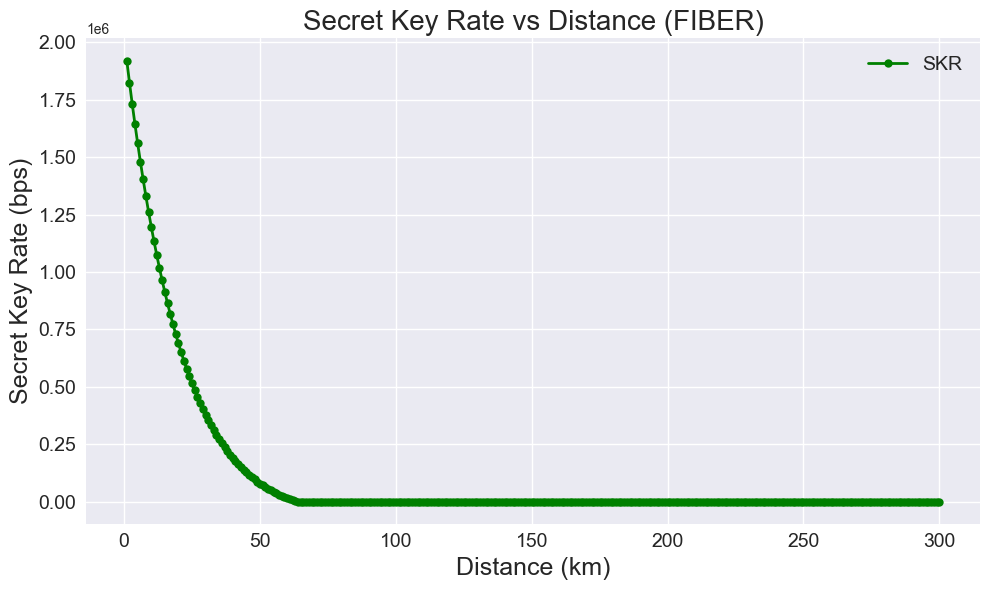

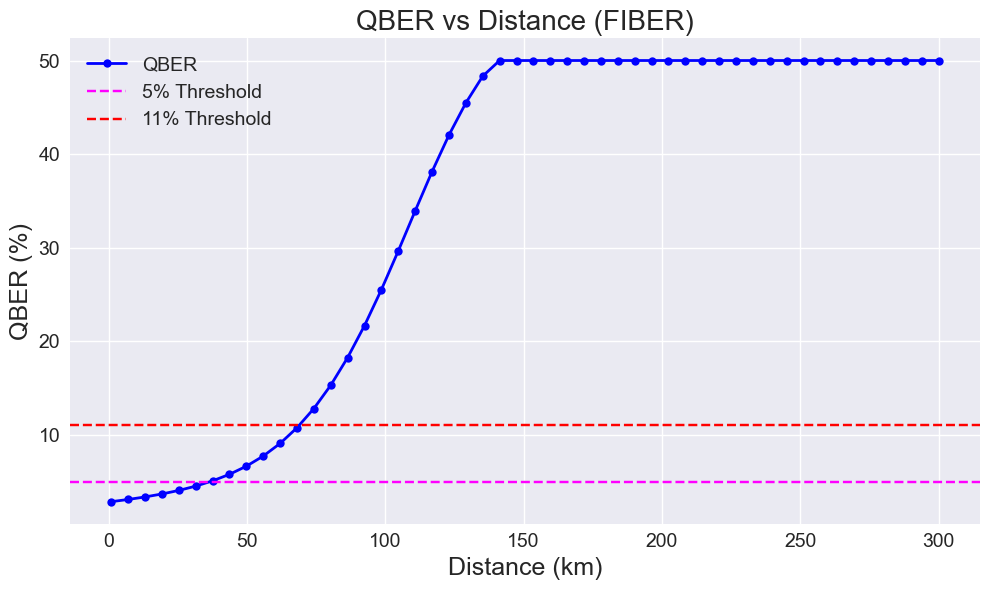

(array([  1.        ,   7.10204082,  13.20408163,  19.30612245,
         25.40816327,  31.51020408,  37.6122449 ,  43.71428571,
         49.81632653,  55.91836735,  62.02040816,  68.12244898,
         74.2244898 ,  80.32653061,  86.42857143,  92.53061224,
         98.63265306, 104.73469388, 110.83673469, 116.93877551,
        123.04081633, 129.14285714, 135.24489796, 141.34693878,
        147.44897959, 153.55102041, 159.65306122, 165.75510204,
        171.85714286, 177.95918367, 184.06122449, 190.16326531,
        196.26530612, 202.36734694, 208.46938776, 214.57142857,
        220.67346939, 226.7755102 , 232.87755102, 238.97959184,
        245.08163265, 251.18367347, 257.28571429, 263.3877551 ,
        269.48979592, 275.59183673, 281.69387755, 287.79591837,
        293.89795918, 300.        ]),
 [np.float64(2.8577317897715506),
  np.float64(3.0921412982262484),
  np.float64(3.362424508296671),
  np.float64(3.6797854617110466),
  np.float64(4.05874308847171),
  np.float64(4.517975689069

In [10]:
plot_skr_vs_distance()
plot_qber_vs_distance()

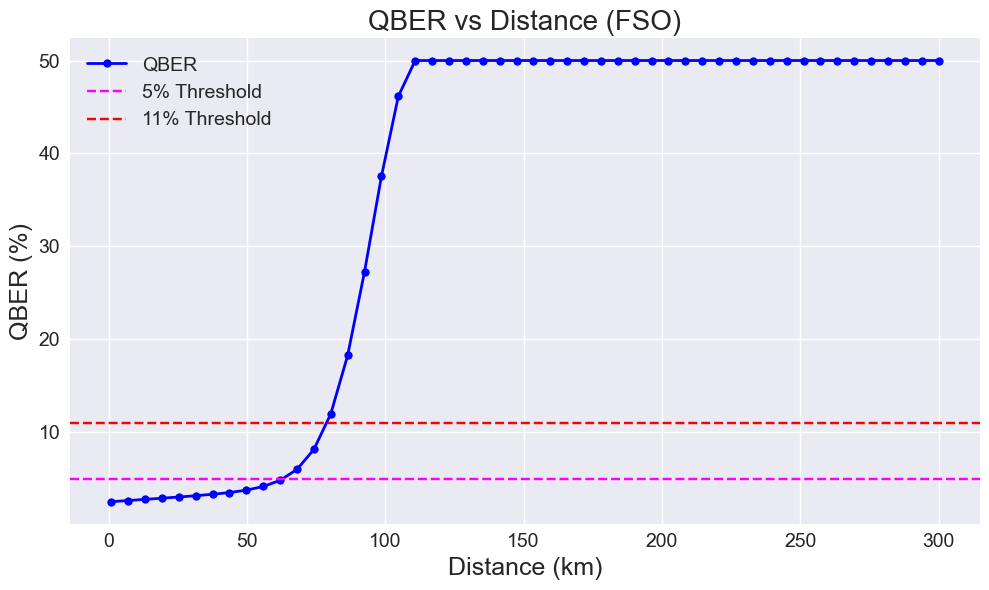

(array([  1.        ,   7.10204082,  13.20408163,  19.30612245,
         25.40816327,  31.51020408,  37.6122449 ,  43.71428571,
         49.81632653,  55.91836735,  62.02040816,  68.12244898,
         74.2244898 ,  80.32653061,  86.42857143,  92.53061224,
         98.63265306, 104.73469388, 110.83673469, 116.93877551,
        123.04081633, 129.14285714, 135.24489796, 141.34693878,
        147.44897959, 153.55102041, 159.65306122, 165.75510204,
        171.85714286, 177.95918367, 184.06122449, 190.16326531,
        196.26530612, 202.36734694, 208.46938776, 214.57142857,
        220.67346939, 226.7755102 , 232.87755102, 238.97959184,
        245.08163265, 251.18367347, 257.28571429, 263.3877551 ,
        269.48979592, 275.59183673, 281.69387755, 287.79591837,
        293.89795918, 300.        ]),
 [np.float64(2.52),
  np.float64(2.6420408163265305),
  np.float64(2.7657147935098734),
  np.float64(2.8916091836924314),
  np.float64(3.0215422126572453),
  np.float64(3.1596984360010896),
  np

In [11]:
plot_qber_vs_distance(channel_type="fso")